# Imports

In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import os
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# ARIMAX

In [2]:
weather_energy_cluster=pd.read_csv("D:/Project/smart-meters-in-london/outputfiles/weather_energy_cluster.csv")

In [3]:
weather_energy_cluster.head(3)

day  energy_sum  LCLid  avg_energy  temperatureMax  windBearing  \
0  2011-11-23      90.385     13    6.952692           10.36          229   
1  2011-11-24     213.412     25    8.536480           12.93          204   
2  2011-11-25     303.993     32    9.499781           13.03          243   

   dewPoint  cloudCover  windSpeed  pressure  ...  uvIndex  temperatureLow  \
0      6.29        0.36       2.04   1027.12  ...      1.0            8.24   
1      8.56        0.41       4.04   1027.22  ...      1.0            9.71   
2      7.24        0.48       5.02   1024.47  ...      1.0            7.01   

   temperatureMin  temperatureHigh  apparentTemperatureMin  moonPhase  \
0            3.81            10.36                    2.18       0.94   
1            8.56            12.93                    7.01       0.97   
2            7.46            12.27                    4.84       0.01   

   Bank holidays  Type  holiday_ind  weather_cluster  
0            NaN   NaN            0                0  
1            NaN   NaN            0                0  
2            NaN   NaN            0                2  

[3 rows x 25 columns]

In [4]:
weather_energy_cluster['Year'] = pd.DatetimeIndex(weather_energy_cluster['day']).year  
weather_energy_cluster['Month'] = pd.DatetimeIndex(weather_energy_cluster['day']).month
weather_energy_cluster.set_index(['day'],inplace=True)

** Subset for required columns and 70-30 train-test split**

In [5]:
model_data = weather_energy_cluster[['avg_energy','weather_cluster','holiday_ind']]
# train = model_data.iloc[0:round(len(model_data)*0.90)]
# test = model_data.iloc[len(train)-1:]
train = model_data.iloc[0:(len(model_data)-30)]
test = model_data.iloc[len(train):(len(model_data)-1)]

In [6]:
len(model_data)

828

In [7]:
train = model_data.iloc[0:(len(model_data)-30)]
train.tail(5)

avg_energy  weather_cluster  holiday_ind
day                                                 
2014-01-25   11.826710                0            0
2014-01-26   12.944640                2            0
2014-01-27   11.960808                2            0
2014-01-28   11.539023                0            0
2014-01-29   12.002336                0            0

In [8]:
len(train)

798

In [9]:
test = model_data.iloc[len(train):(len(model_data)-1)]

In [10]:
test.head(30)

avg_energy  weather_cluster  holiday_ind
day                                                 
2014-01-30   11.886982                0            0
2014-01-31   12.051321                0            0
2014-02-01   11.921217                2            0
2014-02-02   12.291726                2            0
2014-02-03   11.471760                2            0
2014-02-04   11.288728                2            0
2014-02-05   11.602300                2            0
2014-02-06   11.644153                2            0
2014-02-07   11.168278                2            0
2014-02-08   11.769625                2            0
2014-02-09   12.413253                2            0
2014-02-10   11.455522                0            0
2014-02-11   11.642560                2            0
2014-02-12   11.875646                2            0
2014-02-13   11.471329                2            0
2014-02-14   12.024045                2            0
2014-02-15   11.676097                2            0
2014-02-16   11.782755                0            0
2014-02-17   11.164673                0            0
2014-02-18   10.971368                0            0
2014-02-19   10.854245                0            0
2014-02-20   10.754953                2            0
2014-02-21   10.688234                2            0
2014-02-22   10.970704                2            0
2014-02-23   11.673756                2            0
2014-02-24   10.586235                2            0
2014-02-25   10.476498                2            0
2014-02-26   10.375366                2            0
2014-02-27   10.537250                2            0

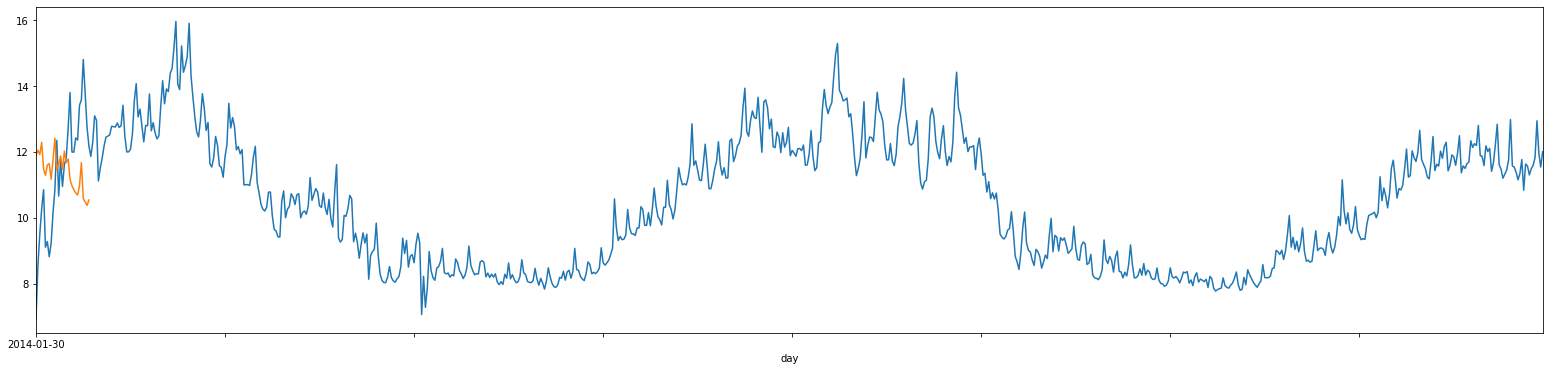

In [34]:
train['avg_energy'].plot(figsize=(27,6))
test['avg_energy'].plot(figsize=(27,6))

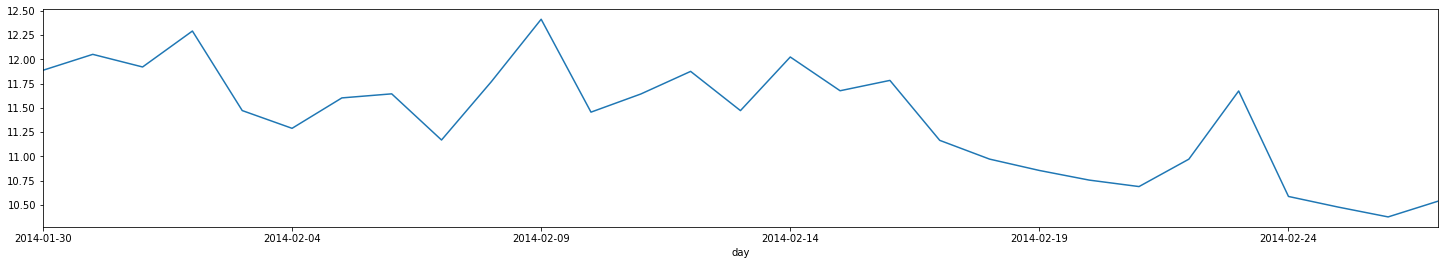

*ACF PACF *

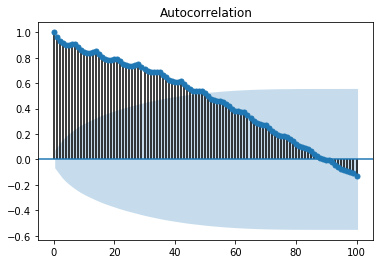

In [13]:
plot_acf(train.avg_energy,lags=100)
plt.show()

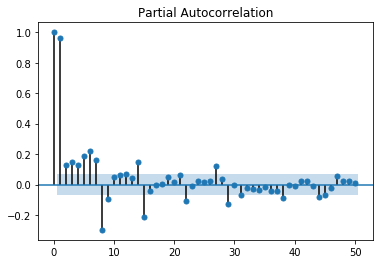

In [14]:
plot_pacf(train.avg_energy,lags=50)
plt.show()

Autocorrelation plot shows gradual decay while Partial AutoCorrelation shows that there is a sharp drop after 1st lag. This means that most of the higher-order autocorrelations are effectively explained by the k = 1 lag. Therefore, the series displays AR 'signature'

# Dickey Fuller's Test
p is greater than 0.05 therefore the data is not stationary. After differencing, p < 0.05.

In [15]:
t = sm.tsa.adfuller(train.avg_energy, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -1.872794
p-value                          0.344966
#Lags Used                      21.000000
Number of Observations Used    776.000000
dtype: float64

In [16]:
# function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [17]:
t  = sm.tsa.adfuller(difference(train.avg_energy,1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                -6.715004e+00
p-value                        3.600554e-09
#Lags Used                     2.000000e+01
Number of Observations Used    7.760000e+02
dtype: float64

# Seasonal Decomposition
The seasonal component is quite low while the trend is quite strong with obvious dips in electricity consumption during summers i.e. April to September. This may be attributed to longer days during summer.

In [18]:
s = sm.tsa.seasonal_decompose(train.avg_energy,freq=12)

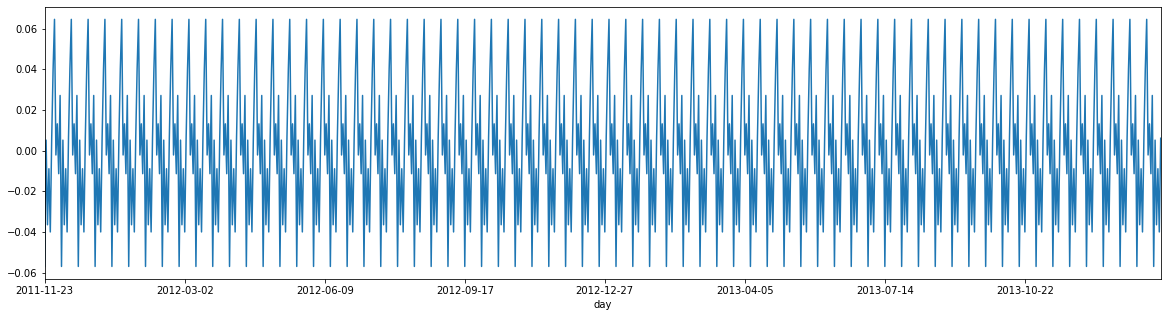

In [19]:
s.seasonal.plot(figsize=(20,5))

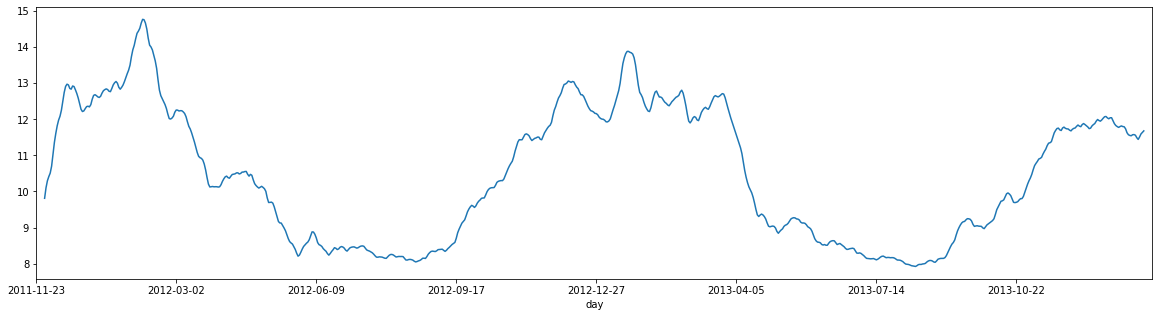

In [20]:
s.trend.plot(figsize=(20,5))

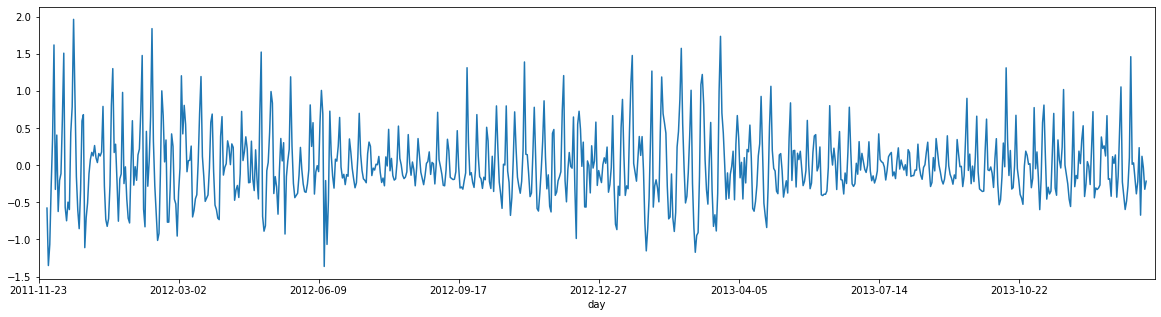

In [21]:
s.resid.plot(figsize=(20,5))

In [22]:
endog = train['avg_energy']
exog = sm.add_constant(train[['weather_cluster','holiday_ind']])

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(7,1,1),seasonal_order=(1,1, 0, 12),trend='c')
model_fit = mod.fit()
model_fit.summary()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         avg_energy   No. Observations:                  798
Model:             SARIMAX(7, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -649.482
Date:                            Sun, 19 Jan 2020   AIC                           1326.964
Time:                                    14:59:59   BIC                           1392.284
Sample:                                         0   HQIC                          1352.079
                                            - 798                                         
Covariance Type:                              opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -0.0064      0.017     -0.384      0.701      -0.039       0.026
const           -2.496e-08   2.34e+05  -1.07e-13      1.000   -4.59e+05    4.59e+05
weather_cluster     0.0041      0.016      0.250      0.803      -0.028       0.036
holiday_ind              0   2.33e+05          0      1.000   -4.56e+05    4.56e+05
ar.L1               0.0008      0.087      0.009      0.993      -0.169       0.171
ar.L2              -0.1551      0.032     -4.843      0.000      -0.218      -0.092
ar.L3              -0.1433      0.038     -3.722      0.000      -0.219      -0.068
ar.L4              -0.1509      0.038     -3.960      0.000      -0.226      -0.076
ar.L5              -0.1623      0.040     -4.068      0.000      -0.240      -0.084
ar.L6               0.0094      0.036      0.260      0.795      -0.061       0.080
ar.L7               0.3523      0.029     12.208      0.000       0.296       0.409
ma.L1              -0.1874      0.091     -2.048      0.041      -0.367      -0.008
ar.S.L12           -0.4832      0.033    -14.773      0.000      -0.547      -0.419
sigma2              0.3042      0.013     23.853      0.000       0.279       0.329
===================================================================================
Ljung-Box (Q):                      220.71   Jarque-Bera (JB):                44.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.23e+19. Standard errors may be unstable.
"""

Model Fit

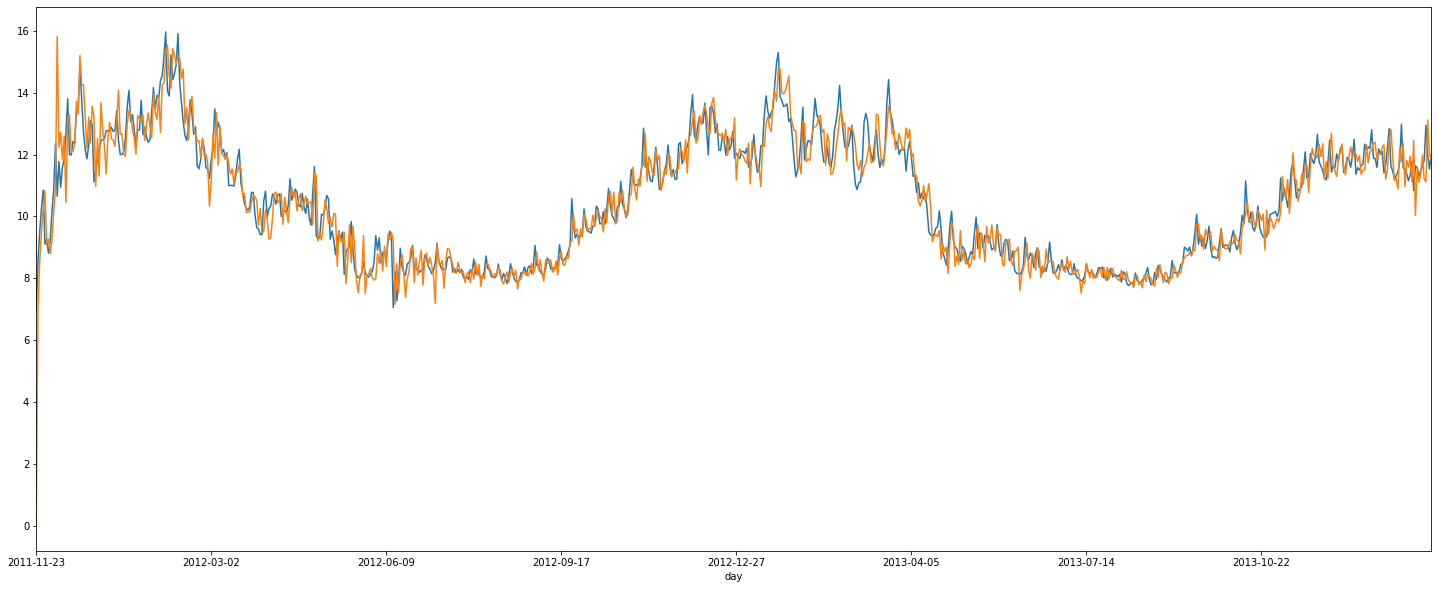

In [23]:
train['avg_energy'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

Prediction

In [24]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['weather_cluster','holiday_ind']]))
test['predicted'] = predict.values
test.tail(5)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


avg_energy  weather_cluster  holiday_ind  predicted
day                                                            
2014-02-23   11.673756                2            0  11.560014
2014-02-24   10.586235                2            0  10.718395
2014-02-25   10.476498                2            0  11.458517
2014-02-26   10.375366                2            0  11.875699
2014-02-27   10.537250                2            0  11.494720

In [25]:
test['residual'] = abs(test['avg_energy']-test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (abs(test['residual'])/test['avg_energy']).sum()*100/len(test)
print("MAE:", MAE)
print("MAPE:", MAPE)

MAE: 0.5862077802775476
MAPE: 5.2486135049806135


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


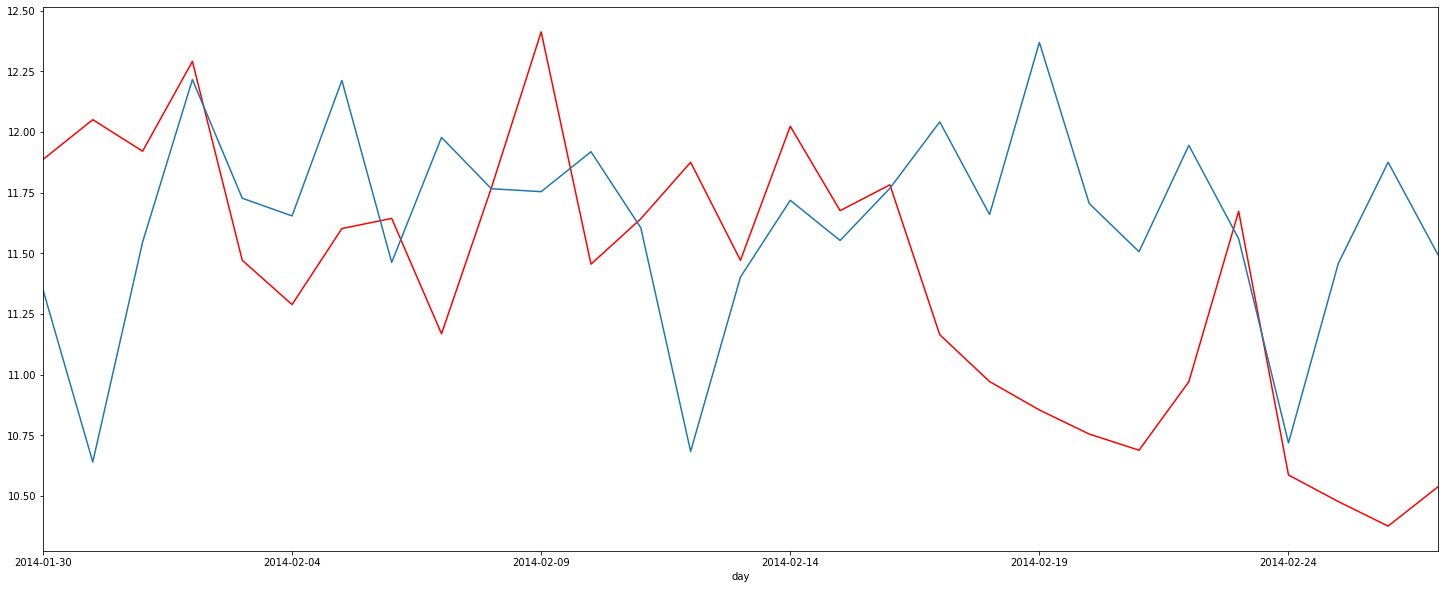

In [26]:
test['avg_energy'].plot(figsize=(25,10),color = 'red')
test['predicted'].plot()
plt.show()

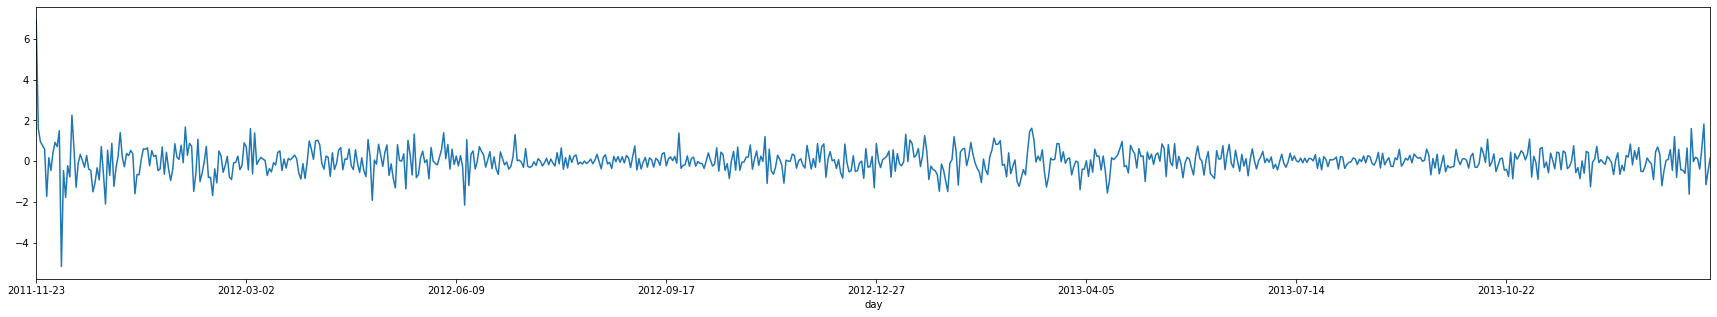

In [27]:
model_fit.resid.plot(figsize= (30,5))

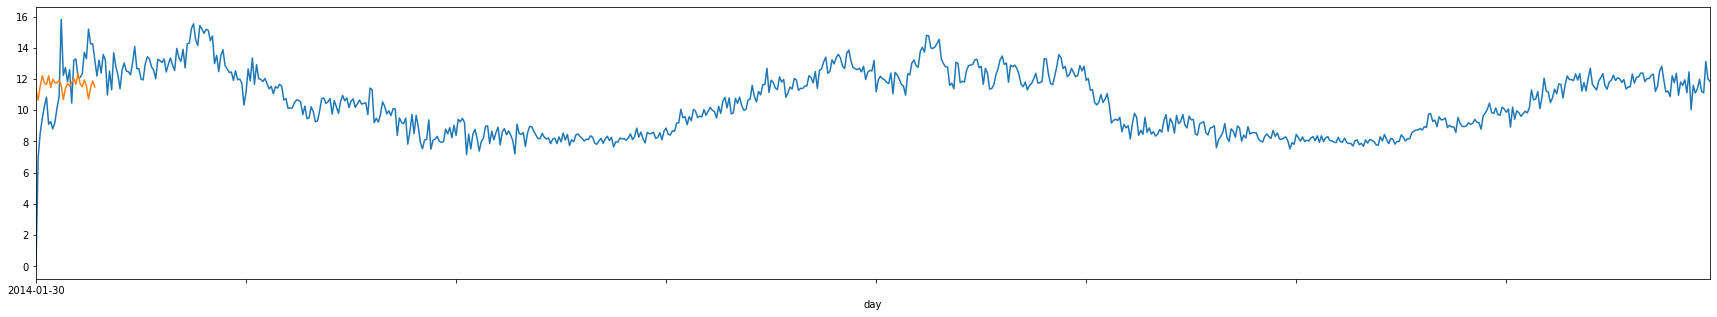

In [28]:
model_fit.fittedvalues.plot(figsize = (30,5))
test.predicted.plot()

In [29]:
test['predicted'].tail(5)

day
2014-02-23    11.560014
2014-02-24    10.718395
2014-02-25    11.458517
2014-02-26    11.875699
2014-02-27    11.494720
Name: predicted, dtype: float64